In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
import random

from tqdm import tqdm

from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor, HistGradientBoostingClassifier, AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, ndcg_score
from sklearn.utils import resample
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, GroupKFold

In [2]:
def score_predict(X_test, y_test, pred):

    df = X_test.copy()
    df['true_y'] = y_test
    df['pred_y'] = pred

    match = sum((df.groupby('srch_id')['true_y'].idxmax() == df.groupby('srch_id')['pred_y'].idxmax()) & (df.groupby('srch_id')['true_y'].max() > 1))

    score = match / df['srch_id'].nunique()
    return score

In [3]:
data = pd.read_csv('data/training_set_VU_DM.csv')
data.drop('date_time', axis = 1, inplace=True)

# data = pd.read_csv('data/FE_training_set.csv')
# data.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
# data['target'] = 5* data['booking_bool'] + data['click_bool']
# data['true_rank'] = data['target']


# #data['target'] = data['booking_bool'] + data['click_bool'] + (1-data['random_bool']) * (1-data['booking_bool']) * (41 - data['position']) / 40
# data['target'].loc[data['target'].isna()] = int(0)
# #data['target'] = data['target'].astype(int)

In [5]:
# target including average booking

data['true_rank'] = data['click_bool'] + 4* data['booking_bool']


# data = data.join(data.groupby('prop_id')['booking_bool'].mean(), on = 'prop_id', rsuffix = '_mean')
# data = data.join(data.groupby('prop_id')['click_bool'].mean(), on = 'prop_id', rsuffix = '_mean')

data['target'] = data['true_rank'].astype(int)
# data['target'] =  (5* data['booking_bool'] + 1* data['booking_bool_mean'] + 1 * data['click_bool'] + 0.2* data['click_bool_mean']) * (5/7.2)

data['target'].loc[data['target'].isna()] = int(0)

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_69715/3463620408.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'].loc[data['target'].isna()] = int(0)


In [6]:
# data['target'] = 1* data['booking_bool'] + data['click_bool']
# data['target'].loc[data['target'].isna()] = int(0)
# data['target'] = data['target'].astype(int)

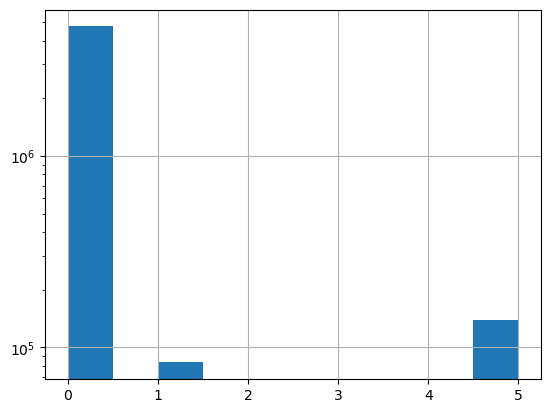

In [7]:
data['target'].hist()
plt.yscale('log')

In [8]:
ids = data['srch_id'].unique()

In [9]:
train_ids = random.sample(list(ids), k = int(0.95* len(ids)))
test_ids = set(ids) - set(train_ids)

In [10]:
# data = data.join(data.loc[data['srch_id'].isin(train_ids)].groupby('prop_id')['booking_bool'].mean(), on = 'prop_id', rsuffix = '_mean')
# data = data.join(data.loc[data['srch_id'].isin(train_ids)].groupby('prop_id')['click_bool'].mean(), on = 'prop_id', rsuffix = '_mean')

In [11]:
train_data = data.loc[data['srch_id'].isin(train_ids)]
test_data = data.loc[data['srch_id'].isin(test_ids)]

In [12]:
# get search ids with any booking
ids_train = train_data['srch_id'].loc[train_data['booking_bool'] == 1].unique()
# use only the searches that resulted in a booking
train_data = train_data.loc[train_data['srch_id'].isin(ids)]
# only use properties that are being booked
props = train_data['prop_id'].loc[train_data['booking_bool'] == 1].unique()
data = train_data.loc[train_data['prop_id'].isin(props)]

In [13]:
#undersample non bookings
X_under, y_under = resample(train_data.drop(['true_rank', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
                                      , axis=1).loc[train_data['target'] < 1], train_data['target'].loc[train_data['target'] < 1]
                                      , n_samples= 1* sum(data['target'] >= 1), replace=False)

In [14]:
X_bal = pd.concat([X_under, train_data.drop(['true_rank', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
                                      , axis=1).loc[train_data['target'] >= 1]])

y_bal = y_under
y_bal = y_bal.append(train_data['target'].loc[train_data['target'] >= 1])

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_69715/2782943548.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_bal = y_bal.append(train_data['target'].loc[train_data['target'] >= 1])


(array([192213.,      0.,  79356.,      0.,      0.,      0.,      0.,
             0.,      0., 131477.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

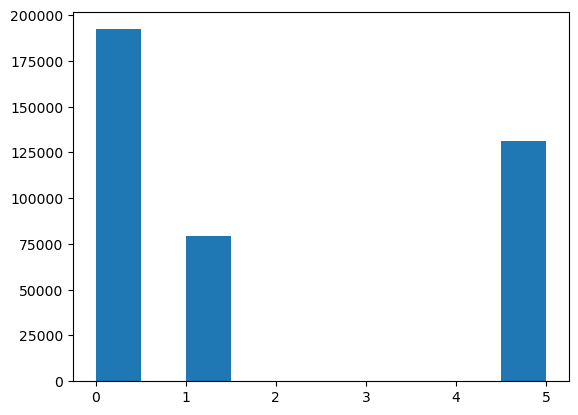

In [15]:
plt.hist(y_bal)

In [16]:
# X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal)

# X_train, X_test, y_train, y_test = train_test_split(data.drop(['booking_bool_mean', 'click_bool_mean', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
#                                        , axis=1), data['target'])
#X_train, y_train = X_bal, y_bal

In [17]:
# much better than just replacing with 0
# X_train = X_train.fillna(-9999)
# baseline = GradientBoostingRegressor(n_estimators = 100, max_leaf_nodes=None, max_depth=3, random_state=42)

baseline = HistGradientBoostingRegressor(random_state=42)
#baseline = GradientBoostingRegressor(random_state=42)
#baseline = AdaBoostRegressor(random_state=42)


In [18]:
# hyper param tuning
# param_dist = {'min_samples_split' : [2, 10_000], 'max_depth' : [3, 15]}
# hp_search = HalvingRandomSearchCV(baseline, param_dist, min_resources=50_000).fit(X_train, y_train)

In [19]:
# hp_search.best_params_

In [20]:
baseline.fit(X_bal.drop(['srch_id'], axis = 1).fillna(-9999),y_bal)

HistGradientBoostingRegressor(random_state=42)

In [21]:
# pred = baseline.predict(data.drop(['srch_id', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target'], axis=1).fillna(-9999))

In [22]:
#mean_squared_error(data['target'], pred)

In [23]:
# pred_test = baseline.predict(X_test.drop(['srch_id'], axis=1).fillna(-9999))
# print('MSE', mean_squared_error(y_test, pred_test))

# score = score_predict(X_test, y_test, pred_test)
# print('score', score)

In [24]:
test_data['pred_score'] = baseline.predict(test_data.drop(['true_rank', 'srch_id', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
                                      , axis=1).fillna(-9999))

In [25]:
print('MSE', mean_squared_error(test_data['target'], test_data['pred_score']))

MSE 3.3451068842017744


In [26]:
test_data['pred_rank'] = test_data.groupby('srch_id')['pred_score'].rank(ascending=False).astype(int)

In [27]:
# scoring with ndcg
mean_ndcg = 0
counter = 0
for id in tqdm(test_ids):
    if len(test_data['true_rank'].loc[test_data['srch_id'] == id]) > 1:
        ndcg = ndcg_score([test_data['true_rank'].loc[test_data['srch_id'] == id].astype(int).to_numpy()],
                        [test_data['pred_score'].loc[test_data['srch_id'] == id].to_numpy()], k = 5)

    mean_ndcg += ndcg
    if ndcg < 1.0:
        counter +=1

mean_ndcg = mean_ndcg/len(test_ids)

100%|██████████| 9990/9990 [00:05<00:00, 1925.45it/s]


In [28]:
mean_ndcg

0.3597675306686504

In [29]:
id = list(test_ids)[223]
print(test_data['true_rank'].loc[test_data['srch_id'] == id].astype(int).to_numpy())
print(test_data['pred_rank'].loc[test_data['srch_id'] == id].to_numpy())
ndcg_score([test_data['true_rank'].loc[test_data['srch_id'] == id].astype(int).to_numpy()], [test_data['pred_score'].loc[test_data['srch_id'] == id].to_numpy()], k = 5)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
[10 15 29 17 23 11 12  4  9  2 18 25 14 22 13 20  8  1 21 24 27  5  3 19
 16 26 28  7  6]


0.0

In [30]:
id = list(test_ids)[12]

test_data[['true_rank', 'pred_score', 'pred_rank']].loc[test_data['srch_id'] == id].head(20)

,true_rank,pred_score,pred_rank
2439978,0,2.235408,8
2439979,0,1.667276,21
2439980,0,1.859103,18
2439981,0,2.739113,5
2439982,0,0.592783,31
2439983,0,1.289367,27
2439984,0,1.559087,24
2439985,0,2.350526,7
2439986,0,2.156428,11
2439987,0,2.208722,9


## Predict the test dataset and bring it into requested format

In [31]:
# test_data = pd.read_csv('data/FE_test_set.csv')
# test_data.drop('Unnamed: 0', axis=1, inplace=True)

test_data = pd.read_csv('data/test_set_VU_DM.csv')
test_data.drop('date_time', axis = 1, inplace=True)

In [32]:
test_data.head()

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff
0,1,24,216,NaN,NaN,219,3180,3,4.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,24,216,NaN,NaN,219,5543,3,4.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,24,216,NaN,NaN,219,14142,2,3.5,1,...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,24,216,NaN,NaN,219,22393,3,4.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,24,216,NaN,NaN,219,24194,3,4.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
test_data['prediction'] = baseline.predict(test_data.drop(['srch_id'], axis=1).fillna(-9999))

# test_data['prediction'] = baseline.predict(test_data.drop(['srch_id', 'date_time'], axis=1).fillna(-9999))

In [34]:
# sort values for final format
test_data.sort_values(['srch_id', 'prediction'], axis=0, inplace=True, ignore_index=True, ascending=[True, False])

In [35]:
filename = 'data/predictions/prediction'+str(datetime.now())+'.csv'
test_data[['srch_id', 'prop_id']].to_csv(filename, index=False)